# Credit Card Transactions Fraud Detection

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Build a model that predicts whether a credit card transaction is fraudulent or not on an imbalanced dataset.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
sns.set_style("whitegrid")

## Load the dataset

In [2]:
file_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"
df = pd.read_csv(file_url)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Understand the dataset

We have access to transaction data from a financial institution that wants to know if a transaction is fraudulent or not. Most transactions are usually legitimate and only a small fraction are not, so the dataset is highly unbalanced.

Each row in the dataset represents a credit card transaction. For confidentiality reasons, the original names of most features are anonymized `V1, V2 .. V28`. The values of these features are the result of a PCA transformation and are numerical. The feature `Class` is the target variable and it takes two values: "1" in case of fraud and "0" otherwise.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Analyze the `Amount` feature

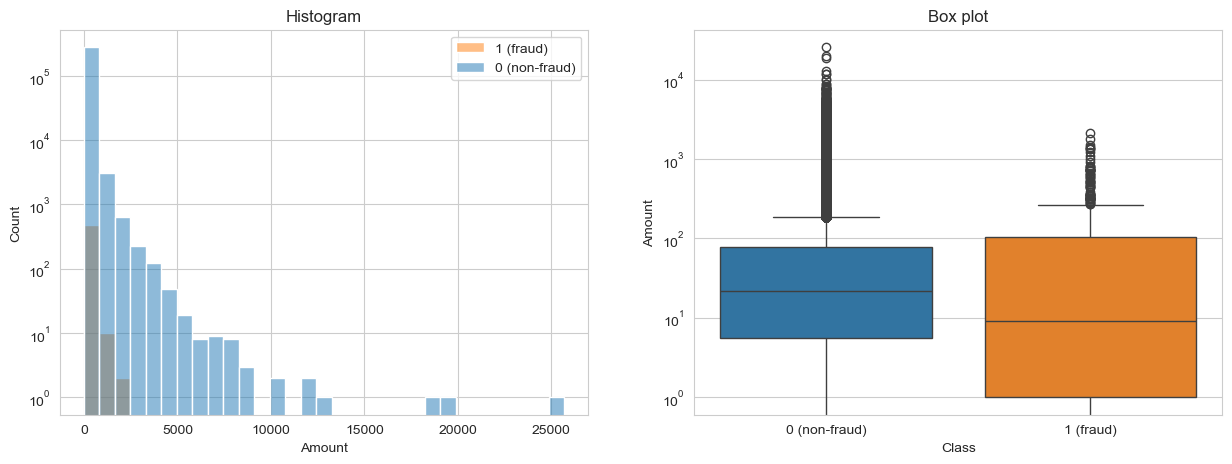

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x="Amount", hue="Class", bins="doane", ax=axs[0])
axs[0].legend(["1 (fraud)", "0 (non-fraud)"])
axs[0].set_yscale('log')
axs[0].set_title("Histogram")

sns.boxplot(data=df, x="Class", y="Amount", hue="Class", ax=axs[1], legend=False)
axs[1].set_xticks(["0", "1"])
axs[1].set_xticklabels(["0 (non-fraud)", "1 (fraud)"])
axs[1].set_yscale('log')
axs[1].set_title("Box plot")

plt.show()

## Visualize the class distribution

As can be seen the dataset is highly unbalanced, so the target variable classes are not equally represented. This case requires special attention when training or when evaluating the quality of a model.

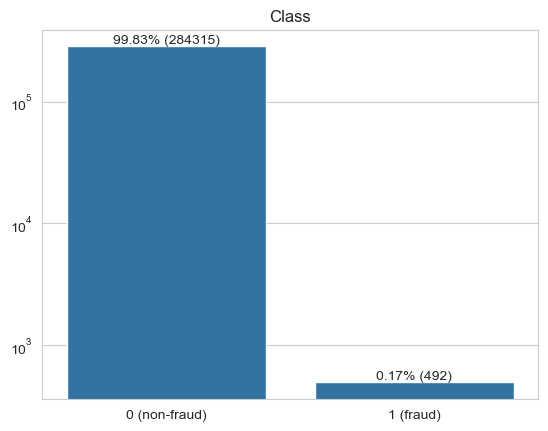

In [5]:
labels, sizes = np.unique(df["Class"], return_counts=True)
labels = ["1 (fraud)" if i else "0 (non-fraud)" for i in labels]

plt.figure()
g = sns.barplot(x=labels, y=sizes)
g.bar_label(g.containers[0], [str(round(100 * size / sum(sizes), 2)) + "%" + " (" + str(size) + ")" for size in sizes])
plt.yscale("log")
plt.title("Class")
plt.show()

## Preprocess the dataset

One way of handling this case at train time is to apply an over-sampling method to pay more attention to the samples in the minority class. [SMOTE (Synthetic Minority Over-sampling TEchnique)](https://arxiv.org/pdf/1106.1813) is a widely used oversampling technique in machine learning to address class imbalance issues in binary classification problems. It generates synthetic minority class samples to balance the class distribution, thereby reducing the impact of class imbalance on model performance. Data preprocessing such as scaling/normalization is typically useful for linear models to accelerate the training convergence.

In [6]:
def preprocess_data(df, smote=False):
    X = df.drop(["Time", "Class"], axis=1)
    y = df["Class"]
    
    if smote:
        sm = SMOTE(random_state=0)
        X, y = sm.fit_resample(X, y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

## Train a Decision Tree classifier without SMOTE

In [7]:
X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (213605, 29)
X_test shape: (71202, 29)


In [8]:
classifier = DecisionTreeClassifier(max_depth=6, random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

## Evaluate the model

              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     71082
           1     0.8879    0.7917    0.8370       120

    accuracy                         0.9995     71202
   macro avg     0.9437    0.8957    0.9184     71202
weighted avg     0.9995    0.9995    0.9995     71202



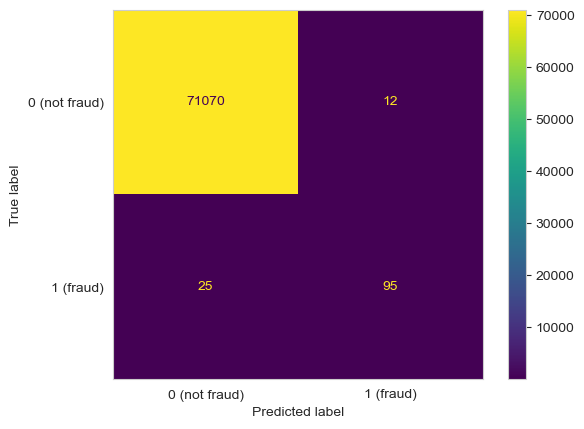

In [9]:
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (not fraud)", "1 (fraud)"])
plt.grid(False)
plt.show()

## Train a Decision Tree classifier with SMOTE

In [10]:
X, y = preprocess_data(df, smote=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (426472, 29)
X_test shape: (142158, 29)


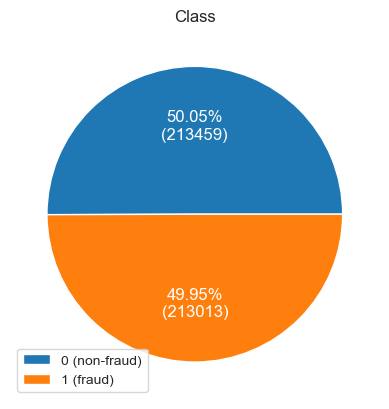

In [11]:
labels, sizes = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots()
ax.pie(sizes, textprops={'color': "w", 'fontsize': '12'}, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, round(pct/100 * sum(sizes))))
ax.legend(["1 (fraud)" if i else "0 (non-fraud)" for i in labels])
ax.set_title("Class")
plt.show()

In [12]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

## Evaluate the model

              precision    recall  f1-score   support

           0     0.9990    0.9978    0.9984     70856
           1     0.9978    0.9990    0.9984     71302

    accuracy                         0.9984    142158
   macro avg     0.9984    0.9984    0.9984    142158
weighted avg     0.9984    0.9984    0.9984    142158



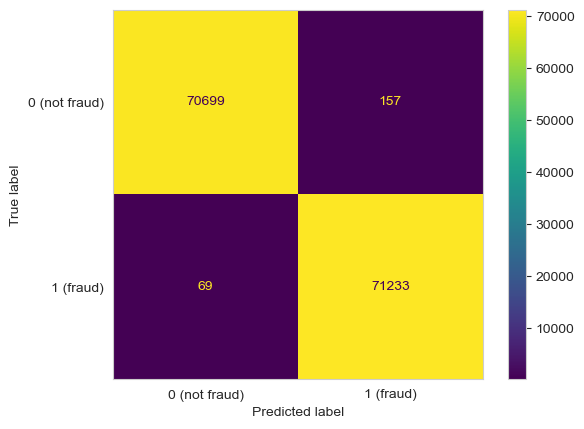

In [13]:
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (not fraud)", "1 (fraud)"])
plt.grid(False)
plt.show()